# Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings; warnings.simplefilter('ignore')
import ast
import re
from timeit import default_timer as timer

C:\Users\dom\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Functions

In [2]:
#Function that writes to csv
def saveData(x):
    x.to_csv('dataintermediate.csv',index=False)

# Data preparation

### Read Data and select columns for Model

In [3]:
df=pd.read_csv('data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

In [4]:
#First I will use most commonsence properties that might influence the property Price
data=df[['status','private pool','baths','homeFacts','fireplace','schools','sqft','beds','state','stories','PrivatePool','propertyType','target']]

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   baths         270847 non-null  object
 3   homeFacts     377185 non-null  object
 4   fireplace     103115 non-null  object
 5   schools       377185 non-null  object
 6   sqft          336608 non-null  object
 7   beds          285903 non-null  object
 8   state         377185 non-null  object
 9   stories       226470 non-null  object
 10  PrivatePool   40311 non-null   object
 11  propertyType  342452 non-null  object
 12  target        374704 non-null  object
dtypes: object(13)
memory usage: 37.4+ MB


## HomeFacts

In [6]:
data['homeFacts']=data['homeFacts'].apply(lambda x: ast.literal_eval(x)['atAGlanceFacts'])


In [7]:
#Get Labels for df columns
def getdata(x):
    Labels=list()
    for i in x:
        Labels.append(i['factLabel'])
    return Labels
Labels=getdata(data.homeFacts[1])
Labels

['Year built',
 'Remodeled year',
 'Heating',
 'Cooling',
 'Parking',
 'lotsize',
 'Price/sqft']

In [8]:
#Convert dictionaries per row to appropriate columns in df and extract all the values
for l in Labels:
    data[l]=data['homeFacts'].apply(lambda x: x[Labels.index(l)]['factValue']) 

In [9]:
saveData(data)

## Schools

In [10]:
data = pd.read_csv('dataintermediate.csv')
data['schools'] = data['schools'].apply(lambda x: ast.literal_eval(x)[0])

In [11]:
#Extract rating list to schRating column
data['schRating'] = data['schools'].apply(lambda x: [n for n in x['rating'] if n != 'NR']) 

In [12]:
def findrating(x):
    '''Function that makes an order in ratings and takes the maximum'''
    l=[0]
    for i in x:
        if (i.find('/')>-1 and i[:i.find('/')] == 'None') or i == 'NA' or i == '':
            l.append(0)
        elif i.find('/')>-1:
            l.append(int(i[:i.find('/')]))
        else:
            l.append(int(i))
    return max(l)

In [13]:
data['schRating'] = data['schRating'].apply(lambda x: findrating(x))

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 21 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          337267 non-null  object 
 1   private pool    4181 non-null    object 
 2   baths           270847 non-null  object 
 3   homeFacts       377185 non-null  object 
 4   fireplace       103115 non-null  object 
 5   schools         377185 non-null  object 
 6   sqft            336608 non-null  object 
 7   beds            285903 non-null  object 
 8   state           377185 non-null  object 
 9   stories         226470 non-null  object 
 10  PrivatePool     40311 non-null   object 
 11  propertyType    342452 non-null  object 
 12  target          374704 non-null  object 
 13  Year built      314811 non-null  object 
 14  Remodeled year  151075 non-null  float64
 15  Heating         267853 non-null  object 
 16  Cooling         253218 non-null  object 
 17  Parking   

### Fill nas in sqft with existing lotsize values

In [15]:
data.lotsize=data.lotsize.str.lower().str.strip()
#Remove all acre substrings and convert the values to float and fill na of sqft with values
data.sqft[(data.sqft.isna()==True)&(data.lotsize.str.contains('acre'))]=data.lotsize[(data.sqft.isna()==True)&(data.lotsize.str.contains('acre'))].str.replace(' acres','').str.replace(',','').str.replace(' acre','').astype(float)*43560.04

In [16]:
#Remove all sq substrings and convert the values to float and fill na of sqft with values
data.sqft[(data.sqft.isna()==True)&(data.lotsize.str.contains('sq'))]=data.lotsize[(data.sqft.isna()==True)&(data.lotsize.str.contains('sq'))].str.replace(' sq. ft.','').str.replace(',','').str.replace(' sqft','').astype(float)*43560.04

## Price/sqft

In [17]:
data['Price/sqft']=data['Price/sqft'].str.lower()

In [18]:
data['Price/sqft']=data['Price/sqft'].str.replace('$',"").str.replace('/sqft','').str.replace(' / sq. ft.','').str.replace(',','')
data['Price/sqft']=data['Price/sqft'].str.replace('no data','0').str.replace('no info','0').str.replace('contact manager','0')

In [19]:
data['Price/sqft'].fillna(0,inplace=True)

In [20]:
data['Price/sqft']=data['Price/sqft'].astype(int)

In [21]:
data['Price/sqft'][(data['Price/sqft']==0)]=data['Price/sqft'][(data['Price/sqft']>0)].mean()

### Price of the Property (target) 

In [22]:
#find symbols that are not numbers to replace
symbollist=data.target.str.findall(r'\D').value_counts().reset_index()['index']
s=list()
for i in symbollist:
    s=s+i
s=list(set(s))
s=''.join(s)
s

',o/m+$ -'

In [23]:
#Function that First remove ",","+","/mo" from all string values then If the string value is a range - take the average
#Function returns for strings it's numeric value
def clean_currency(x):
    """replace redundent symbols"""
    if isinstance(x, str):
        x=x.replace('$','').replace(',','').replace('+','').replace('/mo','')
      
    #for values that appears as range take the average
    if isinstance(x, str) and x.find(' - ')>0:
        a=x.find(' - ')
        return((float(x[:a])+float(x[a+3:]))/2)  
    return(float(x))

In [24]:
data['target'] = data['target'].apply(clean_currency)
data=data.rename(columns={'target':'Price'})

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 21 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          337267 non-null  object 
 1   private pool    4181 non-null    object 
 2   baths           270847 non-null  object 
 3   homeFacts       377185 non-null  object 
 4   fireplace       103115 non-null  object 
 5   schools         377185 non-null  object 
 6   sqft            362944 non-null  object 
 7   beds            285903 non-null  object 
 8   state           377185 non-null  object 
 9   stories         226470 non-null  object 
 10  PrivatePool     40311 non-null   object 
 11  propertyType    342452 non-null  object 
 12  Price           374704 non-null  float64
 13  Year built      314811 non-null  object 
 14  Remodeled year  151075 non-null  float64
 15  Heating         267853 non-null  object 
 16  Cooling         253218 non-null  object 
 17  Parking   

## sqft

In [26]:
#use Area data for filling NAs for sqft
values=data['beds'][data.beds.str.contains('sqft')==True]
valuesA=data['beds'][data.beds.str.contains('acres')==True]
data['sqft'][data.beds.str.contains('sqft')==True]=values
data['sqft'][data.beds.str.contains('acres')==True]=valuesA
data[['beds','sqft']][(data.beds.str.contains('sqft|acres')==True)]
data['beds'][data.beds.str.contains('sqft|arcres')==True]='None'

In [27]:
data.sqft[data.sqft.str.contains(' sqft|,')==True]=data.sqft[data.sqft.str.contains(' sqft|,')==True].str.replace(' sqft','').str.replace(',','')
data.sqft[data.sqft.str.contains('acre')==True]=data.sqft[data.sqft.str.contains('acre')==True].str.replace(' acres','').astype(float)*43560.04
data.sqft[(data.sqft.str.contains('\D')==True)&(data.sqft.isna()==False)]=data.sqft[(data.sqft.str.contains('\D')==True)&(data.sqft.isna()==False)].str.replace('\D','')


In [28]:
#fill blank with 0 of non blank
data.sqft[(data.sqft.isna()==False)&(data.sqft=='')]=0
data.sqft[(data.sqft.isna()==False)]=data.sqft[(data.sqft.isna()==False)].astype(float)

In [29]:
data.sqft[data.sqft>0].value_counts(normalize=True,bins=10)

(-82616057.984, 8261605899.308]       0.999983
(8261605899.308, 16523211797.616]     0.000008
(74354453085.772, 82616058984.08]     0.000003
(24784817695.924, 33046423594.232]    0.000003
(16523211797.616, 24784817695.924]    0.000003
(66092847187.464, 74354453085.772]    0.000000
(57831241289.156, 66092847187.464]    0.000000
(49569635390.848, 57831241289.156]    0.000000
(41308029492.54, 49569635390.848]     0.000000
(33046423594.232, 41308029492.54]     0.000000
Name: sqft, dtype: float64

In [30]:
#Group data according to property type and take the average area for each property type for NA
Area=data[['sqft','propertyType']]
Area['sqft']=Area['sqft'][Area.sqft.isna()==False].astype(float)
Area=Area[Area.sqft.isna()==False].groupby(by='propertyType').mean().reset_index()
Area.sqft=Area.sqft.round(decimals=0)
data.sqft[data.sqft.isna()==True]=data[data.sqft.isna()==True].merge(Area, on='propertyType', how='left').sqft_y


### Use Price, sqft and Price/sqft to fill na's

In [31]:
#replace sqft nas with [Price]/[Price/sqft]
data1=data[['Price/sqft','sqft','Price']][(data.sqft.isna()==True)&(data['Price/sqft'].isna()==False)&(data.Price.isna()==False)&(data['Price/sqft']!='none')]
data1.sqft=data1.Price/data1['Price/sqft']
data['sqft'].iloc[data1.index]=data1.sqft

In [32]:
#replace Price nas with [sqft]*[Price/sqft]
data1=data[['Price/sqft','sqft','Price']][((data.Price.isna()==True)&data.sqft.isna()==False)&(data['Price/sqft'].isna()==False)&(data['Price/sqft']!='none')]
data1.Price=data1.sqft*data1['Price/sqft']
data['Price'].iloc[data1.index]=data1.Price
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 21 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          337267 non-null  object 
 1   private pool    4181 non-null    object 
 2   baths           270847 non-null  object 
 3   homeFacts       377185 non-null  object 
 4   fireplace       103115 non-null  object 
 5   schools         377185 non-null  object 
 6   sqft            377065 non-null  object 
 7   beds            285903 non-null  object 
 8   state           377185 non-null  object 
 9   stories         226470 non-null  object 
 10  PrivatePool     40311 non-null   object 
 11  propertyType    342452 non-null  object 
 12  Price           377065 non-null  object 
 13  Year built      314811 non-null  object 
 14  Remodeled year  151075 non-null  float64
 15  Heating         267853 non-null  object 
 16  Cooling         253218 non-null  object 
 17  Parking   

In [33]:
data.drop(['Price/sqft','lotsize'],axis=1,inplace=True)

### Get rid of the rows where Price and sqft is NA and normalizing

In [34]:
data.dropna(subset=['sqft'],axis=0,inplace=True)
data.dropna(subset=['Price'],axis=0,inplace=True)

In [35]:
data.sqft=data.sqft.astype(float)
data.Price=data.Price.astype(float)

In [36]:
#price distribution
data.Price.value_counts(normalize=True,bins=10)

(-39511741630.596, 3951174163059.548]       0.999984
(3951174163059.548, 7902348326119.096]      0.000008
(35560567467535.93, 39511741630595.48]      0.000003
(11853522489178.645, 15804696652238.191]    0.000003
(7902348326119.096, 11853522489178.645]     0.000003
(31609393304476.383, 35560567467535.93]     0.000000
(27658219141416.836, 31609393304476.383]    0.000000
(23707044978357.29, 27658219141416.836]     0.000000
(19755870815297.74, 23707044978357.29]      0.000000
(15804696652238.191, 19755870815297.74]     0.000000
Name: Price, dtype: float64

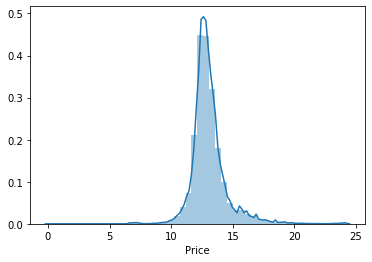

In [37]:
sns.distplot(np.log(data.Price[(data.Price >0)&(data.Price <=34500126672.528)]))

In [38]:
#get rid of exceptions data
data.drop(data.Price[(data.Price <=0)|(data.Price >34500126672.528)].index,axis=0,inplace=True)

In [39]:
#normalizing Price
data.Price=np.log(data.Price)

In [40]:
#sqft distribution
data.sqft.value_counts(normalize=True,bins=20)

(-473933.234, 23696661.762]       0.997948
(47393323.522, 71089985.282]      0.000732
(23696661.762, 47393323.522]      0.000531
(331753264.641, 355449926.401]    0.000085
(260663279.361, 284359941.121]    0.000079
(71089985.282, 94786647.042]      0.000071
(284359941.121, 308056602.881]    0.000065
(213269955.841, 236966617.601]    0.000065
(379146588.16, 402843249.92]      0.000059
(308056602.881, 331753264.641]    0.000057
(355449926.401, 379146588.16]     0.000048
(426539911.68, 450236573.44]      0.000037
(189573294.081, 213269955.841]    0.000037
(402843249.92, 426539911.68]      0.000037
(450236573.44, 473933235.2]       0.000037
(236966617.601, 260663279.361]    0.000028
(142179970.561, 165876632.321]    0.000025
(165876632.321, 189573294.081]    0.000020
(118483308.802, 142179970.561]    0.000020
(94786647.042, 118483308.802]     0.000020
Name: sqft, dtype: float64

In [41]:
data.sqft.value_counts(bins=1000,normalize=True)

(-473933.234, 473933.237]         0.994231
(473933.237, 947866.472]          0.001775
(947866.472, 1421799.708]         0.000529
(1421799.708, 1895732.943]        0.000379
(1895732.943, 2369666.178]        0.000206
                                    ...   
(225118286.721, 225592219.956]    0.000000
(224644353.486, 225118286.721]    0.000000
(224170420.251, 224644353.486]    0.000000
(223696487.016, 224170420.251]    0.000000
(236492684.366, 236966617.601]    0.000000
Name: sqft, Length: 1000, dtype: float64

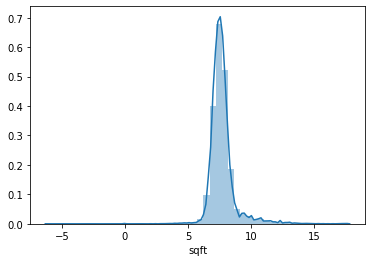

In [42]:
sns.distplot(np.log(data.sqft[(data.sqft >0)&(data.sqft <=47393323.522)]))

In [43]:
#get rid of exceptions data
data.sqft[(data.Price <=0)|(data.Price >=47393323.522)]=data.sqft[(data.Price >0)&(data.Price <=47393323.522)].mean()


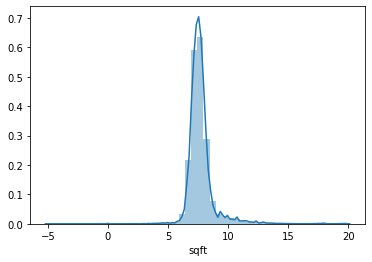

In [44]:
#normalizing sqft
data.sqft=np.log(data.sqft)
sns.distplot(data.sqft)

In [45]:
#data.to_csv('dataintermediate.csv',index=False)
saveData(data)

In [46]:
data=pd.read_csv('dataintermediate.csv')

## Year built and remodeled

In [47]:
data=pd.read_csv('dataintermediate.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 353793 entries, 0 to 353792
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          314341 non-null  object 
 1   private pool    4158 non-null    object 
 2   baths           264713 non-null  object 
 3   homeFacts       353793 non-null  object 
 4   fireplace       102439 non-null  object 
 5   schools         353793 non-null  object 
 6   sqft            353793 non-null  float64
 7   beds            282307 non-null  object 
 8   state           353793 non-null  object 
 9   stories         224600 non-null  object 
 10  PrivatePool     40180 non-null   object 
 11  propertyType    322608 non-null  object 
 12  Price           353793 non-null  float64
 13  Year built      310247 non-null  object 
 14  Remodeled year  150047 non-null  float64
 15  Heating         263671 non-null  object 
 16  Cooling         250819 non-null  object 
 17  Parking   

In [48]:
#put indexes of str and num values in to variables
stri=data['Year built'][data['Year built'].str.contains('\D')==True].index
numi=data['Year built'][data['Year built'].str.contains('\D')==False].index

In [49]:
#replace exeptions where there is no sence (smaller than 0 or bigger than 2020) by No Data
iyearexp=data['Year built'].iloc[numi].astype('int64')[(data['Year built'].iloc[numi].astype('int64')<0)|(data['Year built'].iloc[numi].astype('int64')>2020)].index
data['Year built'].iloc[iyearexp]='No Data'
numi=data['Year built'][data['Year built'].str.contains('\D')==False].index
stri=data['Year built'][data['Year built'].str.contains('\D')==True].index

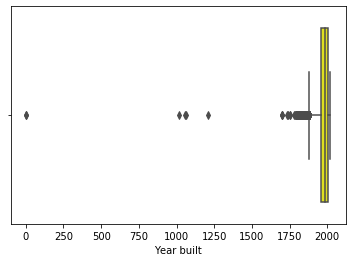

In [50]:
#Check if there are more exeptions
sns.boxplot(data['Year built'].iloc[numi].astype('int64'), color='yellow');

In [51]:
#Drop more exeptions values that smaller than 1500 -> update number indexes value
iyearexp=data['Year built'].iloc[numi].astype('int64')[(data['Year built'].iloc[numi].astype('int64')<1500)|(data['Year built'].iloc[numi].astype('int64')>2020)].index
data['Year built'].iloc[iyearexp]='No Data'
numi=data['Year built'][data['Year built'].str.contains('\D')==False].index
stri=data['Year built'][data['Year built'].str.contains('\D')==True].index

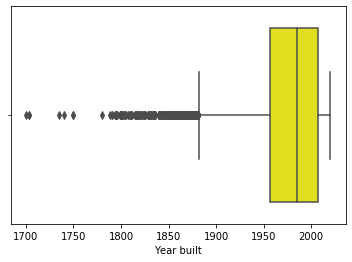

In [52]:
sns.boxplot(data['Year built'].iloc[numi].astype('int64'), color='yellow');

In [53]:
#convert numeric data to integer
data['Year built'].iloc[numi]=data['Year built'].iloc[numi].astype(int)

In [54]:
data['Year built'].iloc[numi].value_counts(normalize=True,bins=10)

(1988.0, 2020.0]      0.470829
(1956.0, 1988.0]      0.281677
(1924.0, 1956.0]      0.168855
(1892.0, 1924.0]      0.070955
(1860.0, 1892.0]      0.006526
(1828.0, 1860.0]      0.000841
(1796.0, 1828.0]      0.000262
(1764.0, 1796.0]      0.000032
(1732.0, 1764.0]      0.000013
(1699.679, 1732.0]    0.000010
Name: Year built, dtype: float64

In [55]:
#replace string data to mean of numeric data
data['Year built'].iloc[stri]=int(round(data['Year built'].iloc[numi].mean(),0))

In [56]:
#fill nas with the mean of numeric values
data['Year built'].fillna(int(round(data['Year built'].iloc[numi].mean(),0)),inplace=True)

In [57]:
data['Year built'].describe()

count    353793.000000
mean       1979.409525
std          31.304869
min        1700.000000
25%        1961.000000
50%        1979.000000
75%        2005.000000
max        2020.000000
Name: Year built, dtype: float64

In [58]:
data['Remodeled year'].fillna(data['Remodeled year'].notnull().mean(),inplace=True)
data['Remodeled year']=data['Remodeled year'].astype(int)

### Status

In [59]:
data.status.value_counts(normalize=True)

for sale                   0.478989
Active                     0.288212
For sale                   0.136374
foreclosure                0.020016
New construction           0.017192
                             ...   
Conting Accpt Backups      0.000003
Lease/Purchase             0.000003
Pending W/Escape Clause    0.000003
Under Contract W/ Bckp     0.000003
Sold: $285,000             0.000003
Name: status, Length: 155, dtype: float64

In [60]:
data.status[data.status.str.contains('for sale|active|accepted')==True]=1

In [61]:
data.status[data.status!=1]=0

In [62]:
data.status=data.status.astype(int)

### Private Pool

In [63]:
data['PrivatePool']=data['PrivatePool'].str.lower()
data['private pool']=data['private pool'].str.lower()

In [64]:
# Replace 'yes' with 1 and unufy "private pool" and PrivatePool and replace NA with 0
data[['private pool','PrivatePool']]=data[['private pool','PrivatePool']].replace(to_replace=['yes'],value=1)
data['PrivatePool']=data['PrivatePool'].fillna(data['private pool'])
data['PrivatePool']=data['PrivatePool'].fillna(0)
data=data.drop(['private pool'],axis=1)

In [65]:
data.PrivatePool=data.PrivatePool.astype(int)
data.PrivatePool.value_counts()

0    309455
1     44338
Name: PrivatePool, dtype: int64

In [66]:
data.head()

,status,baths,homeFacts,fireplace,schools,sqft,beds,state,stories,PrivatePool,propertyType,Price,Year built,Remodeled year,Heating,Cooling,Parking,schRating
0,0,3.5,"[{'factValue': '2019', 'factLabel': 'Year buil...",Gas Logs,"{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR...",7.972466,4,NC,NaN,0,Single Family Home,12.942279,2019,0,"Central A/C, Heat Pump",NaN,NaN,7
1,1,3 Baths,"[{'factValue': '2019', 'factLabel': 'Year buil...",NaN,"{'rating': ['4/10', 'None/10', '4/10'], 'data'...",7.574045,3 Beds,WA,2.0,0,single-family home,12.642949,2019,0,NaN,NaN,NaN,4
2,1,2 Baths,"[{'factValue': '1961', 'factLabel': 'Year buil...",yes,"{'rating': ['8/10', '4/10', '8/10'], 'data': {...",8.006368,3 Beds,CA,1.0,1,single-family home,14.878496,1961,1967,Forced Air,Central,Attached Garage,8
3,1,8 Baths,"[{'factValue': '2006', 'factLabel': 'Year buil...",yes,"{'rating': ['9/10', '9/10', '10/10', '9/10'], ...",8.772920,5 Beds,TX,3.0,0,single-family home,14.689122,2006,2006,Forced Air,Central,Detached Garage,10
4,1,NaN,"[{'factValue': '1920', 'factLabel': 'Year buil...",NaN,"{'rating': [], 'data': {'Distance': [], 'Grade...",6.799056,2 Beds,PA,2.0,0,townhouse,12.250094,1920,0,Forced Air,Central,NaN,0


### Bath

In [67]:
data.baths=data.baths.str.lower()
print(f'There are {round(data.baths.isna().sum()/data.baths.count()*100,0)}% missing values')

There are 34.0% missing values


In [68]:
#Leave cells with numbers only for Bath 
data['baths']=data.baths.str.findall(r'\d').str[0]

In [69]:
data['baths'][data.baths.isna()==False]=data['baths'][data.baths.isna()==False].astype(int)

In [70]:
data.baths.value_counts(normalize=True)

2.0    0.452464
3.0    0.275137
4.0    0.105239
1.0    0.096765
5.0    0.037628
6.0    0.016898
7.0    0.009013
8.0    0.004470
9.0    0.002070
0.0    0.000315
Name: baths, dtype: float64

In [71]:
#Group data according to property type and take the average bathrooms for each property type for NA
Baths=data[['baths','propertyType']]
Baths['baths']=Baths['baths'][Baths.baths.isna()==False].astype(int)
Baths=Baths[Baths.baths.isna()==False].groupby(by='propertyType').mean().reset_index()
Baths.baths=Baths.baths.round(decimals=0)
data.baths[data.baths.isna()==True]=data[data.baths.isna()==True].merge(Baths, on='propertyType', how='left').baths_y
data.head()

,status,baths,homeFacts,fireplace,schools,sqft,beds,state,stories,PrivatePool,propertyType,Price,Year built,Remodeled year,Heating,Cooling,Parking,schRating
0,0,3,"[{'factValue': '2019', 'factLabel': 'Year buil...",Gas Logs,"{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR...",7.972466,4,NC,NaN,0,Single Family Home,12.942279,2019,0,"Central A/C, Heat Pump",NaN,NaN,7
1,1,3,"[{'factValue': '2019', 'factLabel': 'Year buil...",NaN,"{'rating': ['4/10', 'None/10', '4/10'], 'data'...",7.574045,3 Beds,WA,2.0,0,single-family home,12.642949,2019,0,NaN,NaN,NaN,4
2,1,2,"[{'factValue': '1961', 'factLabel': 'Year buil...",yes,"{'rating': ['8/10', '4/10', '8/10'], 'data': {...",8.006368,3 Beds,CA,1.0,1,single-family home,14.878496,1961,1967,Forced Air,Central,Attached Garage,8
3,1,8,"[{'factValue': '2006', 'factLabel': 'Year buil...",yes,"{'rating': ['9/10', '9/10', '10/10', '9/10'], ...",8.772920,5 Beds,TX,3.0,0,single-family home,14.689122,2006,2006,Forced Air,Central,Detached Garage,10
4,1,3,"[{'factValue': '1920', 'factLabel': 'Year buil...",NaN,"{'rating': [], 'data': {'Distance': [], 'Grade...",6.799056,2 Beds,PA,2.0,0,townhouse,12.250094,1920,0,Forced Air,Central,NaN,0


In [72]:
#Group data according to bedrooms and take the average bathrooms for each bedroom number for NA
BathsBeds=data[['baths','beds']]
BathsBeds['baths']=BathsBeds['baths'][BathsBeds.baths.isna()==False].astype(int)
BathsBeds=BathsBeds[BathsBeds.baths.isna()==False].groupby(by='beds').mean().reset_index()
BathsBeds.baths=BathsBeds.baths.round(decimals=0)
data.baths[data.baths.isna()==True]=data[data.baths.isna()==True].merge(BathsBeds, on='beds', how='left').baths_y
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 353793 entries, 0 to 353792
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          353793 non-null  int32  
 1   baths           280806 non-null  object 
 2   homeFacts       353793 non-null  object 
 3   fireplace       102439 non-null  object 
 4   schools         353793 non-null  object 
 5   sqft            353793 non-null  float64
 6   beds            282307 non-null  object 
 7   state           353793 non-null  object 
 8   stories         224600 non-null  object 
 9   PrivatePool     353793 non-null  int32  
 10  propertyType    322608 non-null  object 
 11  Price           353793 non-null  float64
 12  Year built      353793 non-null  int64  
 13  Remodeled year  353793 non-null  int32  
 14  Heating         263671 non-null  object 
 15  Cooling         250819 non-null  object 
 16  Parking         199611 non-null  object 
 17  schRating 

In [73]:
#check if some values can be taken from beds column
data['beds'][(data.beds.str.contains('Bath'))&(data.beds.isna()==False)&(data.baths.isna()==True)]

114        Bath
923       Baths
1290      Baths
1401       Bath
2126      Baths
          ...  
352961    Baths
353116     Bath
353120    Baths
353278    Baths
353394     Bath
Name: beds, Length: 1204, dtype: object

In [74]:
#beds columns has values that contains baths, replace NA with 1 for bath and 2 for baths
data['beds'][(data.beds=='Bath')&(data.beds.isna()==False)&(data.baths.isna()==True)]=1
data['beds'][(data.beds=='Baths')&(data.beds.isna()==False)&(data.baths.isna()==True)]=2
data['baths'][(data.beds.str.contains('Bath'))&(data.beds.isna()==False)&(data.baths.isna()==True)]=1

In [75]:
#Group data according to sqft and take the average bathrooms for each area for NA
BathsArea=data[['baths','sqft']]
BathsArea['baths']=BathsArea['baths'][BathsArea.baths.isna()==False].astype(int)
BathsArea=BathsArea[BathsArea.baths.isna()==False].groupby(by='sqft').mean().reset_index()
BathsArea.baths=BathsArea.baths.round(decimals=0)
data.baths[data.baths.isna()==True]=data[data.baths.isna()==True].merge(BathsArea, on='sqft', how='left').baths_y

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 353793 entries, 0 to 353792
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          353793 non-null  int32  
 1   baths           284751 non-null  object 
 2   homeFacts       353793 non-null  object 
 3   fireplace       102439 non-null  object 
 4   schools         353793 non-null  object 
 5   sqft            353793 non-null  float64
 6   beds            282307 non-null  object 
 7   state           353793 non-null  object 
 8   stories         224600 non-null  object 
 9   PrivatePool     353793 non-null  int32  
 10  propertyType    322608 non-null  object 
 11  Price           353793 non-null  float64
 12  Year built      353793 non-null  int64  
 13  Remodeled year  353793 non-null  int32  
 14  Heating         263671 non-null  object 
 15  Cooling         250819 non-null  object 
 16  Parking         199611 non-null  object 
 17  schRating 

In [76]:
data.baths.fillna(1,inplace=True)
data.baths=data.baths.astype(int)

### Beds

In [78]:
data.beds=data.beds.str.lower()
print(f'There are {round(data.beds.isna().sum()/data.baths.count()*100,0)}% of missing values')

There are 21.0% of missing values


In [79]:
data.beds.value_counts(normalize=True)

3 beds         0.189795
4 beds         0.125616
3              0.110981
2 beds         0.093564
4              0.070835
                 ...   
33 beds        0.000004
7.82 acres     0.000004
23.72 acres    0.000004
5.3 acres      0.000004
10.32 acres    0.000004
Name: beds, Length: 587, dtype: float64

In [80]:
#leave numbers only for Beds
data['beds']=data.beds.str.replace(' beds','').str.replace(' bd','')
data['beds']=data.beds.str.replace('baths','2')
data['beds']=data.beds.str.replace('bath','1')
data.beds[(data.beds.str.contains('\D')==True)&(data.beds.isna()==False)].value_counts(normalize=True)

3.0           0.363398
4.0           0.235644
2.0           0.107752
none          0.061665
5.0           0.061526
                ...   
8.55 acres    0.000046
26.5 acres    0.000046
4.57 acres    0.000046
3.48 acres    0.000046
10.7 acres    0.000046
Name: beds, Length: 473, dtype: float64

In [81]:
data['beds'][data.beds.str.contains('sqft|acres|acre| |--')==True]=0


In [82]:
data['beds'][data.beds.str.contains('2 bedrooms')==True]=2
data['beds'][data.beds.str.contains('3 or more bedrooms')==True]=3
data['beds'][data.beds.str.contains('based on redfin|-')==True]=1

In [83]:
data['beds']=data['beds'][(data.beds.isna()==False)&(data.beds!='none')].astype(float)

In [84]:
#Group data according to property type and take the average area for each property type for NA
Beds=data[['beds','propertyType']]
Beds['beds']=Beds['beds'][(Beds.beds.isna()==False)&(Beds.beds!='none')].astype(float)
Beds=Beds.groupby(by='propertyType').mean().reset_index()
Beds.beds=Beds.beds.round(decimals=0)
data=data.merge(Beds, on='propertyType', how='left')

In [85]:
data['beds_x'].fillna(data.beds_y,inplace=True)
data['beds_x'][data.beds_x=='none']=data.beds_y
data.beds_x.fillna(data.beds_x.mean(),inplace=True)
data.drop('beds_y',axis=1,inplace=True)
data=data.rename(columns={'beds_x':'beds'})
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 353793 entries, 0 to 353792
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          353793 non-null  int32  
 1   baths           353793 non-null  int32  
 2   homeFacts       353793 non-null  object 
 3   fireplace       102439 non-null  object 
 4   schools         353793 non-null  object 
 5   sqft            353793 non-null  float64
 6   beds            353793 non-null  float64
 7   state           353793 non-null  object 
 8   stories         224600 non-null  object 
 9   PrivatePool     353793 non-null  int32  
 10  propertyType    322608 non-null  object 
 11  Price           353793 non-null  float64
 12  Year built      353793 non-null  int64  
 13  Remodeled year  353793 non-null  int32  
 14  Heating         263671 non-null  object 
 15  Cooling         250819 non-null  object 
 16  Parking         199611 non-null  object 
 17  schRating 

In [86]:
data.beds.value_counts(normalize=True,bins=10)

(-0.145, 14.4]    0.999073
(14.4, 28.8]      0.000681
(57.6, 72.0]      0.000107
(28.8, 43.2]      0.000088
(43.2, 57.6]      0.000031
(72.0, 86.4]      0.000011
(86.4, 100.8]     0.000006
(129.6, 144.0]    0.000003
(115.2, 129.6]    0.000000
(100.8, 115.2]    0.000000
Name: beds, dtype: float64

In [87]:
data=data.drop(data.beds[data.beds>15].index)

In [88]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 353498 entries, 0 to 353792
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          353498 non-null  int32  
 1   baths           353498 non-null  int32  
 2   homeFacts       353498 non-null  object 
 3   fireplace       102408 non-null  object 
 4   schools         353498 non-null  object 
 5   sqft            353498 non-null  float64
 6   beds            353498 non-null  float64
 7   state           353498 non-null  object 
 8   stories         224465 non-null  object 
 9   PrivatePool     353498 non-null  int32  
 10  propertyType    322313 non-null  object 
 11  Price           353498 non-null  float64
 12  Year built      353498 non-null  int64  
 13  Remodeled year  353498 non-null  int32  
 14  Heating         263500 non-null  object 
 15  Cooling         250681 non-null  object 
 16  Parking         199449 non-null  object 
 17  schRating 

### Create feature baths per bedroom

In [89]:
data['baths'][data['baths']<1]=1
data['beds'][data['beds']<1]=1
data['baths/bed']=data['beds']/data['baths']

In [90]:
#data.to_csv('dataintermediate.csv',index=False)
saveData(data)

### Fireplace

In [91]:
data=pd.read_csv('dataintermediate.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 353498 entries, 0 to 353497
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          353498 non-null  int64  
 1   baths           353498 non-null  int64  
 2   homeFacts       353498 non-null  object 
 3   fireplace       102408 non-null  object 
 4   schools         353498 non-null  object 
 5   sqft            353498 non-null  float64
 6   beds            353498 non-null  float64
 7   state           353498 non-null  object 
 8   stories         224465 non-null  object 
 9   PrivatePool     353498 non-null  int64  
 10  propertyType    322313 non-null  object 
 11  Price           353498 non-null  float64
 12  Year built      353498 non-null  int64  
 13  Remodeled year  353498 non-null  int64  
 14  Heating         263500 non-null  object 
 15  Cooling         250681 non-null  object 
 16  Parking         199449 non-null  object 
 17  schRating 

In [92]:
data['fireplace']=data['fireplace'].str.lower()
data.fireplace[data.fireplace.str.contains('fire|yes|gas|burning|stove|frplc')==True]=1
data.fireplace[data.fireplace.str.contains('no|0 ')==True]=0
data.fireplace[(data.fireplace.str.contains('\d')==True)&(data.fireplace.str.contains('0')==False)]=1
data.fireplace[data.fireplace!=1]=0

In [93]:
data.fireplace=data.fireplace.astype(int)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 353498 entries, 0 to 353497
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          353498 non-null  int64  
 1   baths           353498 non-null  int64  
 2   homeFacts       353498 non-null  object 
 3   fireplace       353498 non-null  int32  
 4   schools         353498 non-null  object 
 5   sqft            353498 non-null  float64
 6   beds            353498 non-null  float64
 7   state           353498 non-null  object 
 8   stories         224465 non-null  object 
 9   PrivatePool     353498 non-null  int64  
 10  propertyType    322313 non-null  object 
 11  Price           353498 non-null  float64
 12  Year built      353498 non-null  int64  
 13  Remodeled year  353498 non-null  int64  
 14  Heating         263500 non-null  object 
 15  Cooling         250681 non-null  object 
 16  Parking         199449 non-null  object 
 17  schRating 

### Stories

In [94]:
data.stories=data.stories.str.lower()

In [95]:
data['st1']=data.stories.str.findall(r'\d').str[0]
data.stories[(data.st1.isna()==True)&(data.stories.isna()==False)].value_counts()

one                   5751
two                   2487
three or more          567
one story              394
townhouse              325
                      ... 
hillside                 1
two, three or more       1
multi/split, two         1
patio home               1
log home                 1
Name: stories, Length: 91, dtype: int64

In [96]:
data.stories[data.stories.str.contains('one')==True]=1
data.stories[data.stories.str.contains('two')==True]=2

In [97]:
data.stories=data['st1'][(data.st1.isna()==False)&(data.stories.isna()==False)]

In [98]:
data.drop('st1',axis=1,inplace=True)
data.dropna(subset=['stories'],axis=0,inplace=True)

In [99]:
data.stories=data.stories.astype(int)

In [100]:
data['stories'][data.stories<2]=1
data['stories'][data.stories>1]=2

In [101]:
data.stories.value_counts()

1    107080
2    105958
Name: stories, dtype: int64

In [102]:
saveData(data)

### Parking

In [103]:
data=pd.read_csv('dataintermediate.csv')
data.Parking.value_counts()

Attached Garage                                                                                      55637
2 spaces                                                                                             24462
1 space                                                                                              11388
No Data                                                                                               9630
Detached Garage                                                                                       8946
                                                                                                     ...  
Attached Garage, Back Load Garage, Driveway, Garage - 3 Car, Garage Door Opener, Keypad Entry            1
Attached, Facing Side, Garage Door Opener, Guest Parking Avail, RV Attached, Uncov Prkng Spc (2+)        1
Gravel Driveway, Concrete Driveway                                                                       1
Boat, Circular Driveway, Driveway, Ga

In [104]:
data.Parking[data.Parking.notnull()==True]=data.Parking[data.Parking.notnull()==True].str.lower()
data.Parking[(data.Parking.notnull()==True)&(data.Parking.str.contains('no')==True)]=0
data.Parking[(data.Parking.notnull()==True)]=1


In [105]:
data.Parking.fillna(0,inplace=True)
data.Parking.astype(int)

0         0
1         1
2         1
3         0
4         1
         ..
213033    1
213034    1
213035    1
213036    1
213037    1
Name: Parking, Length: 213038, dtype: int32

## Density per state- additional data

In [106]:
url = 'https://www.census.gov/data/tables/2010/dec/density-data-text.html'  

In [107]:
pd.read_html(url)[0].to_csv('density2010.csv',index=False)
density=pd.read_csv('density2010.csv')

In [108]:
density2010=pd.DataFrame(density.iloc[3::4]['2010'].values,columns=['statefull'])
density2010['density']=density.iloc[5::4]['2010'].values
density2010.head()

,statefull,density
0,Alabama,94.4
1,Alaska,1.2
2,Arizona,56.3
3,Arkansas,56.0
4,California,239.1


In [109]:
url1 = 'https://en.wikipedia.org/wiki/List_of_U.S._state_and_territory_abbreviations'  
pd.read_html(url1)[0].iloc[11:,[0,3]].dropna().to_csv('abrv.csv',index=False)
stateabrv=pd.read_csv('abrv.csv')
stateabrv.head()

,"Codes: ISO ISO 3166 codes (2-letter, 3-letter, and 3-digit codes from ISO 3166-1; 2+2-letter codes from ISO 3166-2) ANSI 2-letter and 2-digit codes from the ANSI standard INCITS 38:2009 (supersedes FIPS 5-2) USPS 2-letter codes used by the United States Postal Service USCG 2-letter codes used by the United States Coast Guard (bold red text shows differences between ANSI and USCG) Abbreviations: GPO Older variable-length official US Government Printing Office abbreviations AP Abbreviations from the AP Stylebook (bold red text shows differences between GPO and AP)","Codes: ISO ISO 3166 codes (2-letter, 3-letter, and 3-digit codes from ISO 3166-1; 2+2-letter codes from ISO 3166-2) ANSI 2-letter and 2-digit codes from the ANSI standard INCITS 38:2009 (supersedes FIPS 5-2) USPS 2-letter codes used by the United States Postal Service USCG 2-letter codes used by the United States Coast Guard (bold red text shows differences between ANSI and USCG) Abbreviations: GPO Older variable-length official US Government Printing Office abbreviations AP Abbreviations from the AP Stylebook (bold red text shows differences between GPO and AP).3"
0,Alabama,AL
1,Alaska,AK
2,Arizona,AZ
3,Arkansas,AR
4,California,CA


In [110]:
stateabrv.columns=['statefull','state']

In [111]:
density2010=density2010.merge(stateabrv, on='statefull', how='left')
density2010.head()

,statefull,density,state
0,Alabama,94.4,AL
1,Alaska,1.2,AK
2,Arizona,56.3,AZ
3,Arkansas,56.0,AR
4,California,239.1,CA


In [112]:
data.state=data.state.astype(str)

In [113]:
data.state

0         WA
1         CA
2         TX
3         PA
4         TX
          ..
213033    DC
213034    FL
213035    IL
213036    NY
213037    TX
Name: state, Length: 213038, dtype: object

In [114]:
data=data.merge(density2010, on='state', how='left')

In [115]:
data.density=data.density.astype(float)

## Features table

In [116]:
Features=data[['stories','fireplace','sqft','PrivatePool','Year built','Remodeled year','baths/bed','Parking','schRating','density','status']]
target=data.Price

In [117]:
Features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213038 entries, 0 to 213037
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   stories         213038 non-null  int64  
 1   fireplace       213038 non-null  int64  
 2   sqft            213038 non-null  float64
 3   PrivatePool     213038 non-null  int64  
 4   Year built      213038 non-null  int64  
 5   Remodeled year  213038 non-null  int64  
 6   baths/bed       213038 non-null  float64
 7   Parking         213038 non-null  int64  
 8   schRating       213038 non-null  int64  
 9   density         213038 non-null  float64
 10  status          213038 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 19.5 MB


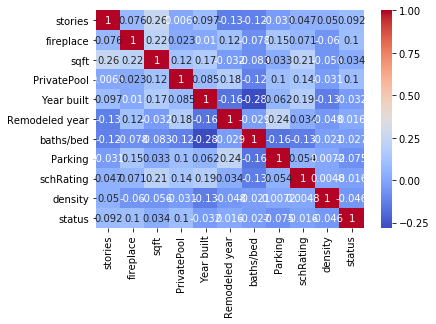

In [118]:
sns.heatmap(Features.corr(), annot=True, cmap='coolwarm')
#most of the variables have low correlation

# Model

In [119]:
import numpy as np
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor,AdaBoostRegressor
from sklearn.model_selection import train_test_split,KFold
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from tqdm import tqdm
from sklearn.base import clone


In [120]:
scaler = StandardScaler()
FeaturesSt=scaler.fit_transform(Features)

In [121]:
X_train, X_test, y_train, y_test = train_test_split(FeaturesSt, target, test_size=0.5)
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

X_train: (106519, 11)
X_test: (106519, 11)
y_train: (106519,)
y_test: (106519,)


In [122]:
def compute_meta_feature(regr, X_train, X_test, y_train, cv):
    """
    Computes meta-features using the regressor.
    
    :arg regr: scikit-learn regressor
    :args X_train, y_train: training set
    :arg X_test: testing set
    :arg cv: cross-validation folding
    """
    X_meta_train = np.zeros_like(y_train, dtype=np.float32)
    for train_fold_index, predict_fold_index in cv.split(X_train):
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]
        
        folded_r = clone(regr)
        folded_r.fit(X_fold_train, y_fold_train)
        X_meta_train[predict_fold_index] = folded_r.predict(X_fold_predict)
    
    meta_r = clone(regr)
    meta_r.fit(X_train, y_train)
    
    X_meta_test = meta_r.predict(X_test)
    
    return X_meta_train, X_meta_test

In [123]:
def generate_metafeatures(regrs, X_train, X_test, y_train, cv):
    """
    Generates metafeatures using a list of regressors.
    
    :arg regrs: list of scikit-learn regressors
    :args X_train, y_train: training set
    :arg X_test: testing set
    :arg cv: cross-validation folding
    """
    features = [
        compute_meta_feature(regr, X_train, X_test, y_train, cv)
        for regr in tqdm(regrs)
    ]
    
    stacked_features_train = np.vstack([
        features_train for features_train, features_test in features
    ]).T

    stacked_features_test = np.vstack([
        features_test for features_train, features_test in features
    ]).T
    
    return stacked_features_train, stacked_features_test

In [124]:
LR =  LinearRegression()
DTR = DecisionTreeRegressor(max_depth=30)
ABR = AdaBoostRegressor(LR, learning_rate=0.8)
RFR = RandomForestRegressor(max_depth=30)
GBR = GradientBoostingRegressor(n_estimators=200, learning_rate=0.3)

In [125]:
cv = KFold(n_splits=100, shuffle=True)
stacked_features_train, stacked_features_test = generate_metafeatures([DTR,ABR,RFR,GBR],X_train, X_test, y_train.values, cv)

100%|████████████████████████████████████████| 4/4 [1:39:23<00:00, 1424.99s/it]


In [126]:
total_features_train = np.hstack([X_train, stacked_features_train])
total_features_test = np.hstack([X_test, stacked_features_test])

In [127]:
predictor = LinearRegression()
predictor.fit(total_features_train, y_train)
y_pred=predictor.predict(total_features_test)

In [128]:
mae=mean_absolute_error(y_test,y_pred)
mse=mean_squared_error(y_test,y_pred)
print(f'R^2 GB: {round(predictor.score(total_features_test,y_test),4)}, MAE GB: {round(mae,2)}, RSME: {round(np.sqrt(mse),2)}')

R^2 GB: 0.7385, MAE GB: 0.35, RSME: 0.52


During my work the score has inceased from 0.1 at the beginning to what I have now. This is not the best score and probably additional work is required for data and ML. 
- add more features the distance from center based on street and additional data of central street in each city, heating, cooling 
- optimize parameters for basic algorithms
- increase the NA treatments
- increase exceptions treatment
- code refactoring and style improvement
- Prepare the models to Production

But this is scheduled for the next sprint :)
